In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import statsmodels.formula.api as sm
import itertools as it
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [2]:
#optimize recall = minimizing FNR + model accuracy (goal)

In [3]:
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
    pred_values = model.predict_proba(data)[:,1]
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    recall = 100 - fnr 
    print("Accuracy = ", accuracy)
    print("FNR = ", fnr)
    print("Precision = ", precision)
    print("Recall = ", recall)
    print("Confusion matrix = \n", cm_df)
    return (" ")
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
def plot_roc_curve(fpr, tpr, label = None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0, 1, 0.05), rotation = 90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

In [4]:
data = pd.read_csv("mushrooms.csv")
data = data.filter(["class", "gill-attachment", "gill-spacing", "gill-size", "gill-color"])

In [5]:
#transform all predictors into dummy variables 
#1 == poisonious, 0 = edible 
X = pd.get_dummies(data, prefix_sep = '', columns = data.columns.drop('class')).drop(['class'], axis = 1)
y = np.where(data["class"] == "e", 0, 1)

In [6]:
#splitting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1)

### Decision Tree Classifier

In [7]:
#param grid to find max_depth and max_leaf_nodes that optimize recall 
param_grid = {'max_depth': range(5, 20),
              'max_leaf_nodes': range(10, 50)}
skf = StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 1), param_grid, 
                           scoring = ['precision', 'accuracy', 'recall'], refit = "recall", 
                           cv = skf, n_jobs = -1, verbose = True)
grid_search.fit(X_train, y_train)
print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Best params for recall
{'max_depth': 8, 'max_leaf_nodes': 12}


In [7]:
#fit model with optimized max_depth and max_leaf_nodes, max_depth = 10, max_leaf_nodes = 30
model = DecisionTreeClassifier(random_state = 1, max_depth = 8, max_leaf_nodes = 15).fit(X_train, y_train)

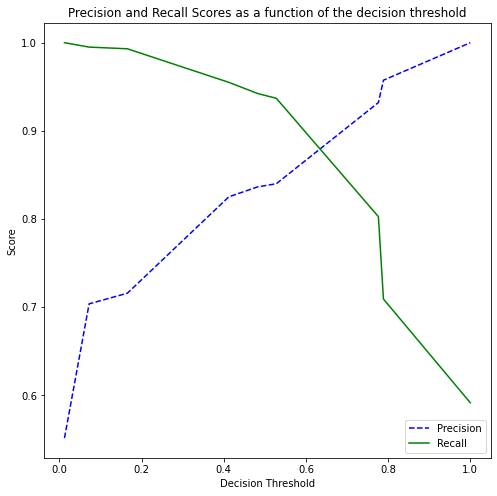

In [8]:
ypred = model.predict_proba(X_train)[:, 1]
p, r, thresholds = precision_recall_curve(y_train, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

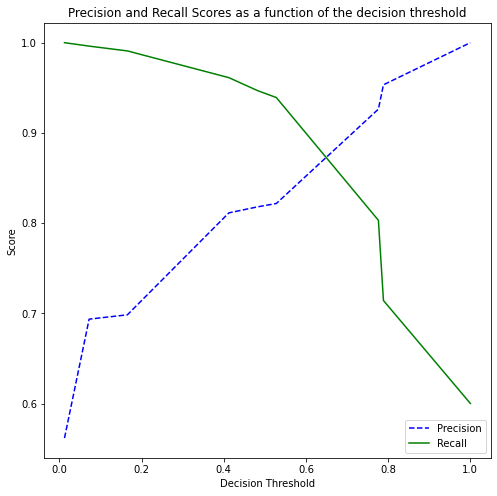

In [9]:
ypred = model.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [10]:
print(confusion_matrix_data(X_train, y_train, model))

Accuracy =  88.46224508543082
FNR =  6.3076923076923075
Precision =  84.0
Recall =  93.6923076923077
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       2379.0        464.0
Actual 1        164.0       2436.0
 


In [11]:
print(confusion_matrix_data(X_test, y_test, model))

Accuracy =  87.01976874300634
FNR =  6.079027355623101
Precision =  82.18085106382979
Recall =  93.9209726443769
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1097.0        268.0
Actual 1         80.0       1236.0
 


ROC-AUC: 0.9580093412160282


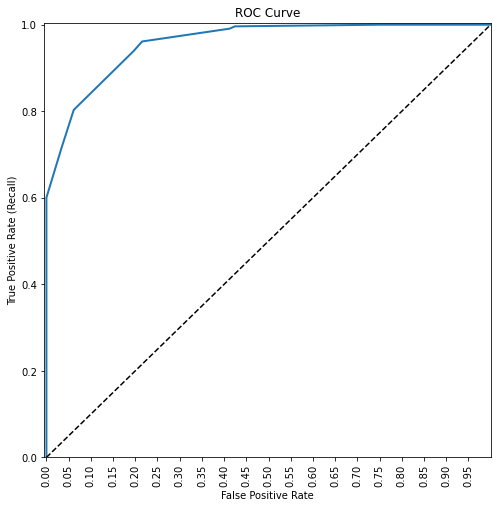

In [12]:
fpr, tpr, auc_thresholds = roc_curve(y_test, ypred)
plot_roc_curve(fpr, tpr)
print("ROC-AUC:", auc(fpr, tpr))

### Random Forest maximizing recall

In [17]:
params = {'n_estimators': [500],
          'max_features': range(1,3),
          'max_depth': [2,4,6,8,10],
          'min_samples_leaf': [1,2,3,4,5]
         }
param_list=list(it.product(*(params[Name] for Name in list(params.keys()))))
recall = [0]*len(param_list)
fnr = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestClassifier(random_state=1,oob_score=True,verbose=False,n_estimators= pr[0],
                                   max_features=pr[1], 
                                   max_depth=pr[2],
                                   min_samples_leaf=pr[3],
                                   n_jobs=-1).fit(X_train,y_train)
    oob_pred = model.oob_decision_function_[:,1]
    bins=np.array([0,0.5,1])
    cm = np.histogram2d(y_train, oob_pred, bins=bins)[0]
    recall[i] = 100*(cm[1,1])/(cm[1,0]+cm[1,1])
    fnr[i] = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    i=i+1
print("max recall = ", np.max(recall))
print("params= ", param_list[np.argmax(recall)])

max recall =  85.73076923076923
params=  (500, 1, 10, 2)


In [18]:
model = RandomForestClassifier(random_state=1,oob_score=True,verbose=False,n_estimators= 500,
                               max_features=1, 
                               max_depth=10,
                               min_samples_leaf=2,
                               n_jobs=-1).fit(X_train,y_train)

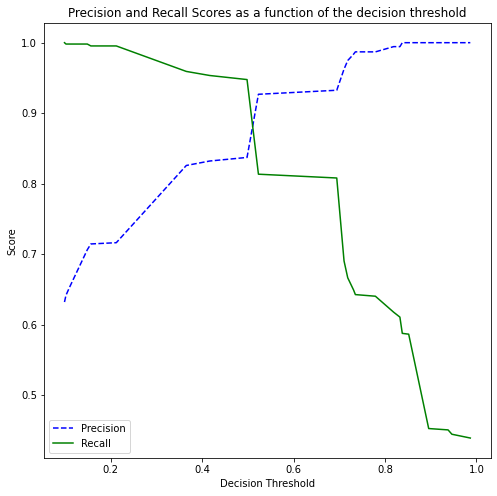

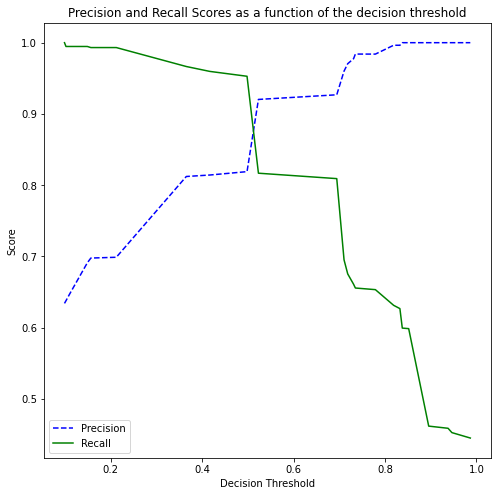

In [19]:
ypred = model.predict_proba(X_train)[:, 1]
p, r, thresholds = precision_recall_curve(y_train, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)
ypred = model.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [20]:
print(confusion_matrix_data(X_train, y_train, model))
print(confusion_matrix_data(X_test, y_test, model))

Accuracy =  88.02131177659379
FNR =  18.653846153846153
Precision =  92.68185801928134
Recall =  81.34615384615384
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       2676.0        167.0
Actual 1        485.0       2115.0
 
Accuracy =  87.5419619544946
FNR =  18.31306990881459
Precision =  92.03767123287672
Recall =  81.68693009118542
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1272.0         93.0
Actual 1        241.0       1075.0
 


### AdaBoost

In [21]:
model = AdaBoostClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=1),
                          DecisionTreeClassifier(max_depth=2),
                          DecisionTreeClassifier(max_depth=3),
                          DecisionTreeClassifier(max_depth=4)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                           scoring=['recall','accuracy'],refit='recall')
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.948077 using {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.01, 'n_estimators': 500}


In [22]:
model = AdaBoostClassifier(random_state=1,
                           base_estimator =DecisionTreeClassifier(max_depth=3),
                           learning_rate=0.01,
                           n_estimators=500).fit(X_train,y_train)

In [23]:
print(confusion_matrix_data(X_train, y_train, model))
print(confusion_matrix_data(X_test, y_test, model))

Accuracy =  88.7010839610509
FNR =  5.230769230769231
Precision =  83.7240910635406
Recall =  94.76923076923077
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       2364.0        479.0
Actual 1        136.0       2464.0
 
Accuracy =  87.35546437896308
FNR =  4.711246200607903
Precision =  81.90725016329196
Recall =  95.2887537993921
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1088.0        277.0
Actual 1         62.0       1254.0
 


### Gradient Boosting

In [24]:
model = GradientBoostingClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['max_depth'] = [1,2,3,4,5]
grid['subsample'] = [0.5,1.0]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                           scoring=['recall','accuracy'],refit='recall')
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.947692 using {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500, 'subsample': 1.0}


In [25]:
model = GradientBoostingClassifier(random_state=1,
                                   learning_rate=0.1,
                                   max_depth=2,
                                   n_estimators=500,
                                   subsample = 1.0).fit(X_train,y_train)

In [26]:
print(confusion_matrix_data(X_train, y_train, model))
print(confusion_matrix_data(X_test, y_test, model))

Accuracy =  88.7010839610509
FNR =  5.230769230769231
Precision =  83.7240910635406
Recall =  94.76923076923077
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       2364.0        479.0
Actual 1        136.0       2464.0
 
Accuracy =  87.35546437896308
FNR =  4.711246200607903
Precision =  81.90725016329196
Recall =  95.2887537993921
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1088.0        277.0
Actual 1         62.0       1254.0
 


### XGBoost

In [29]:
param_grid = {'n_estimators':[25,100,500],
              'max_depth': [6,7,8],
              'learning_rate': [0.01,0.1,0.2],
              'gamma': [0.1,0.25,0.5],
              'reg_lambda':[0,0.01,0.001],
              'scale_pos_weight':[1.25,1.5,1.75]
             }
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,
                                                          use_label_encoder=False),
                              param_grid = param_grid,
                              scoring = ['accuracy','recall'],
                              refit = 'recall',
                              verbose = 1, n_jobs=-1, cv = cv)
optimal_params.fit(X_train,y_train)
print(optimal_params.best_params_,optimal_params.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 0.01, 'scale_pos_weight': 1.75} 0.9542307692307691


In [7]:
model = xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,
                  gamma=0.1,learning_rate = 0.1,max_depth=6,
                  n_estimators = 100,reg_lambda = 0.01,
                  scale_pos_weight=1.75,use_label_encoder=False)
model.fit(X_train,y_train,eval_metric='error')

C:\Users\nvsim\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=0.01, ...)

In [8]:
print(confusion_matrix_data(X_train, y_train, model))
print(confusion_matrix_data(X_test, y_test, model))

Accuracy =  88.38875620062466
FNR =  4.076923076923077
Precision =  82.58278145695364
Recall =  95.92307692307692
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       2317.0        526.0
Actual 1        106.0       2494.0
 
Accuracy =  87.39276389406938
FNR =  3.3434650455927053
Precision =  81.22605363984674
Recall =  96.65653495440729
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1071.0        294.0
Actual 1         44.0       1272.0
 


### Ensemble

In [9]:
# Decision Tree
tree_model =  DecisionTreeClassifier(random_state = 1, max_depth = 8, max_leaf_nodes = 15).fit(X_train, y_train)

# Random Forest
forest_model = RandomForestClassifier(random_state=1,oob_score=True,verbose=False,n_estimators= 500,
                               max_features=1, 
                               max_depth=10,
                               min_samples_leaf=2,
                               n_jobs=-1).fit(X_train,y_train)

# AdaBoost
ada_model = AdaBoostClassifier(random_state=1,
                           base_estimator =DecisionTreeClassifier(max_depth=3),
                           learning_rate=0.01,
                           n_estimators=500).fit(X_train,y_train)

# Gradient Boosting
grad_model = GradientBoostingClassifier(random_state=1,
                                   learning_rate=0.1,
                                   max_depth=2,
                                   n_estimators=500,
                                   subsample = 1.0).fit(X_train,y_train)

# XGBoost
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,
                  gamma=0.1,learning_rate = 0.1,max_depth=6,
                  n_estimators = 100,reg_lambda = 0.01,
                  scale_pos_weight=1.75,use_label_encoder=False)

In [10]:
def confusion_matrix_data_ensembling(data,actual_values,model,cutoff=0.5):
    pred_values = model.predict(data)
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    recall = 100 - fnr 
    print("Accuracy = ", accuracy)
    print("FNR = ", fnr)
    print("Precision = ", precision)
    print("Recall = ", recall)
    print("Confusion matrix = \n", cm_df)
    return (" ")

#### Hard Voting Classifier

In [13]:
ensemble_model = VotingClassifier(estimators=[('tree', tree_model),
                                              ('rf', forest_model),
                                              ('ada',ada_model),
                                              ('gb',grad_model),
                                              ('xgb',xgb_model)])
ensemble_model.fit(X_train,y_train)

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(max_depth=8,
                                                     max_leaf_nodes=15,
                                                     random_state=1)),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     max_features=1,
                                                     min_samples_leaf=2,
                                                     n_estimators=500,
                                                     n_jobs=-1, oob_score=True,
                                                     random_state=1,
                                                     verbose=False)),
                             ('ada',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                                 learning_rate=0.0...
          

In [23]:
print(confusion_matrix_data_ensembling(X_train, y_train, ensemble_model))
print(confusion_matrix_data_ensembling(X_test, y_test, ensemble_model))

Accuracy =  88.7010839610509
FNR =  5.230769230769231
Precision =  83.7240910635406
Recall =  94.76923076923077
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       2364.0        479.0
Actual 1        136.0       2464.0
 
Accuracy =  87.35546437896308
FNR =  4.711246200607903
Precision =  81.90725016329196
Recall =  95.2887537993921
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1088.0        277.0
Actual 1         62.0       1254.0
 


#### Stacking classifier w/ logistic regression as meta model

In [18]:
ensemble_model = StackingClassifier(estimators=[('tree', tree_model),
                                              ('rf', forest_model),
                                              ('ada',ada_model),
                                              ('gb',grad_model),
                                              ('xgb',xgb_model)],
                                    final_estimator=LogisticRegression(random_state=1,
                                                                       max_iter=10000),
                                    n_jobs=-1,
                                    cv =StratifiedKFold(n_splits=5,
                                                        shuffle=True,
                                                        random_state=1))
ensemble_model.fit(X_train,y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimators=[('tree',
                                DecisionTreeClassifier(max_depth=8,
                                                       max_leaf_nodes=15,
                                                       random_state=1)),
                               ('rf',
                                RandomForestClassifier(max_depth=10,
                                                       max_features=1,
                                                       min_samples_leaf=2,
                                                       n_estimators=500,
                                                       n_jobs=-1,
                                                       oob_score=True,
                                                       random_state=1,
                                                       verbose=False)),
                               ('ada',
                   

In [19]:
print(confusion_matrix_data_ensembling(X_train, y_train, ensemble_model))
print(confusion_matrix_data_ensembling(X_test, y_test, ensemble_model))

Accuracy =  88.7010839610509
FNR =  5.230769230769231
Precision =  83.7240910635406
Recall =  94.76923076923077
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       2364.0        479.0
Actual 1        136.0       2464.0
 
Accuracy =  87.35546437896308
FNR =  4.711246200607903
Precision =  81.90725016329196
Recall =  95.2887537993921
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1088.0        277.0
Actual 1         62.0       1254.0
 


#### Stacking classifier w/ random forest as meta model

In [20]:
params = {'n_estimators': [500],
          'max_features': range(1,3),
          'max_depth': [2,4,6,8,10],
          'min_samples_leaf': [1,2,3,4,5]
         }
param_list=list(it.product(*(params[Name] for Name in list(params.keys()))))
oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = StackingClassifier(estimators=[('tree', tree_model),
                                              ('rf', forest_model),
                                              ('ada',ada_model),
                                              ('gb',grad_model),
                                              ('xgb',xgb_model)],
                               final_estimator=RandomForestClassifier(n_estimators=500, 
                                                                      max_features=1,
                                                                      random_state=1,
                                                                      oob_score=True),
                               n_jobs=-1,
                               cv =StratifiedKFold(n_splits=5,
                                                   shuffle=True,
                                                   random_state=1))
    model.fit(X_train,y_train)
    oob_score[i] = model.final_estimator_.oob_score_
    i=i+1
print("max oob score = ", np.max(oob_score))
print("params= ", param_list[np.argmax(oob_score)])

max oob score =  0.8833363953702003
params=  (500, 1, 2, 1)


In [21]:
ensemble_model = StackingClassifier(estimators=[('tree', tree_model),
                                              ('rf', forest_model),
                                              ('ada',ada_model),
                                              ('gb',grad_model),
                                              ('xgb',xgb_model)],
                                    final_estimator=RandomForestClassifier(n_estimators=500, 
                                                                           max_features=1,
                                                                           max_depth=2,
                                                                           min_samples_leaf=1,
                                                                           random_state=1,
                                                                           oob_score=True),
                                    n_jobs=-1,
                                    cv =StratifiedKFold(n_splits=5,
                                                        shuffle=True,
                                                        random_state=1))
ensemble_model.fit(X_train,y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimators=[('tree',
                                DecisionTreeClassifier(max_depth=8,
                                                       max_leaf_nodes=15,
                                                       random_state=1)),
                               ('rf',
                                RandomForestClassifier(max_depth=10,
                                                       max_features=1,
                                                       min_samples_leaf=2,
                                                       n_estimators=500,
                                                       n_jobs=-1,
                                                       oob_score=True,
                                                       random_state=1,
                                                       verbose=False)),
                               ('ada',
                   

In [22]:
print(confusion_matrix_data_ensembling(X_train, y_train, ensemble_model))
print(confusion_matrix_data_ensembling(X_test, y_test, ensemble_model))

Accuracy =  88.7010839610509
FNR =  5.230769230769231
Precision =  83.7240910635406
Recall =  94.76923076923077
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       2364.0        479.0
Actual 1        136.0       2464.0
 
Accuracy =  87.35546437896308
FNR =  4.711246200607903
Precision =  81.90725016329196
Recall =  95.2887537993921
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1088.0        277.0
Actual 1         62.0       1254.0
 
